# Token Level 

## Import Dependencies  

In [1]:
import numpy as np
import os 
from itertools import repeat 
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from cleanlab.rank import get_label_quality_scores 
from utils import readfile, get_probs, get_pred_probs 

from cleanlab.internal.token_classification_utils import get_sentence, filter_sentence
import matplotlib.pyplot as plt 
os.environ["TOKENIZERS_PARALLELISM"] = "false" 
from sklearn import metrics 

2022-10-09 00:39:07.101922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 00:39:07.101944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read datasets: original CoNLL-2003 & CoNLL++ 

In [2]:
filepath = 'data/conll.txt'
given_words, given_labels = readfile(filepath) 
sentences = list(map(get_sentence, given_words)) 

sentences, mask = filter_sentence(sentences) 
given_words = [words for m, words in zip(mask, given_words) if m] 
given_labels = [labels for m, labels in zip(mask, given_labels) if m] 
labels = [label for given_label in given_labels for label in given_label] 

In [3]:
ground_truth_path = 'data/conllpp.txt' 
ground_truth_labels = readfile(ground_truth_path)[1] 
ground_truth_labels = [label for m, label in zip(mask, ground_truth_labels) if m] 
ground_truth_labels = [label for labels in ground_truth_labels for label in labels] 

## Distribution of mislabels 

The cell in the $i$th row and $j$th column below lists the number (or percentage) of tokens that are labeled class i in CoNLL++ (ground truth label) and labeled as class j in the original CoNLL-2003 dataset. 

In [4]:
cm = metrics.confusion_matrix(ground_truth_labels, labels) 
entities = ['O', 'B-MISC', 'I-MISC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'] 

print('\t' + '\t'.join(entities)) 
for entity, dist in zip(entities, cm): 
    s = [str(d) for d in dist] 
    print(entity + '\t' + '\t'.join(s)) 

	O	B-MISC	I-MISC	B-PER	I-PER	B-ORG	I-ORG	B-LOC	I-LOC
O	38132	3	6	2	0	3	0	1	0
B-MISC	39	665	0	0	0	1	0	18	0
I-MISC	48	4	202	0	0	0	0	0	0
B-PER	8	2	0	1603	0	1	0	3	0
I-PER	2	0	0	5	1153	0	0	0	1
B-ORG	14	20	0	3	0	1644	0	32	0
I-ORG	28	0	6	0	3	3	831	2	7
B-LOC	15	8	0	3	0	7	1	1612	0
I-LOC	7	0	2	0	0	0	1	0	249


In [5]:
percentage = np.sum(cm, axis=1)[:, np.newaxis] 
percentage = cm / percentage * 100 
percentage = np.round(percentage, 2) 

def reformat(val): 
    val = str(val) 
    val = val + '%' if val.index('.') == len(val)-3 else val + '0%' 
    val = ' ' * (6-len(val)) + val 
    return val 

print('\t' + '\t'.join(entities)) 
for entity, per in zip(entities, percentage): 
    s = [reformat(p) for p in per] 
    print(entity + '\t' + '\t'.join(s)) 

	O	B-MISC	I-MISC	B-PER	I-PER	B-ORG	I-ORG	B-LOC	I-LOC
O	99.96%	 0.01%	 0.02%	 0.01%	 0.00%	 0.01%	 0.00%	 0.00%	 0.00%
B-MISC	 5.39%	91.98%	 0.00%	 0.00%	 0.00%	 0.14%	 0.00%	 2.49%	 0.00%
I-MISC	18.90%	 1.57%	79.53%	 0.00%	 0.00%	 0.00%	 0.00%	 0.00%	 0.00%
B-PER	 0.49%	 0.12%	 0.00%	99.13%	 0.00%	 0.06%	 0.00%	 0.19%	 0.00%
I-PER	 0.17%	 0.00%	 0.00%	 0.43%	99.31%	 0.00%	 0.00%	 0.00%	 0.09%
B-ORG	 0.82%	 1.17%	 0.00%	 0.18%	 0.00%	95.97%	 0.00%	 1.87%	 0.00%
I-ORG	 3.18%	 0.00%	 0.68%	 0.00%	 0.34%	 0.34%	94.43%	 0.23%	 0.80%
B-LOC	 0.91%	 0.49%	 0.00%	 0.18%	 0.00%	 0.43%	 0.06%	97.93%	 0.00%
I-LOC	 2.70%	 0.00%	 0.77%	 0.00%	 0.00%	 0.00%	 0.39%	 0.00%	96.14%


## Token-level label error detection 

In [6]:
model_name = 'dslim/bert-base-NER'
model = AutoModelForTokenClassification.from_pretrained(model_name) 
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline(task="ner", model=model, tokenizer=tokenizer)

sentence_tokens = [[tokenizer.decode(token) for token in tokenizer(sentence)['input_ids']] for sentence in sentences] 
sentence_tokens = [[token.replace('#', '') for token in sentence_token][1:-1] for sentence_token in sentence_tokens] 

errors = np.array(ground_truth_labels) != np.array(labels) 
n_error = sum(errors) 
error_percentage = n_error / len(errors) 

In [7]:
sentence_probs = list(map(get_probs, repeat(pipe), sentences))
pred_probs = list(map(get_pred_probs, sentence_probs, sentence_tokens, given_words)) 
pred_probs = [pred for pred_prob in pred_probs for pred in pred_prob] 
pred_probs = np.array(pred_probs) 

                              AUPRC     AUPRC     Lift @ Error
self_confidence               0.3483    0.9545    62.4867   
normalized_margin             0.3296    0.9552    66.3618   
confidence_weighted_entropy   0.2293    0.9355    46.9861   


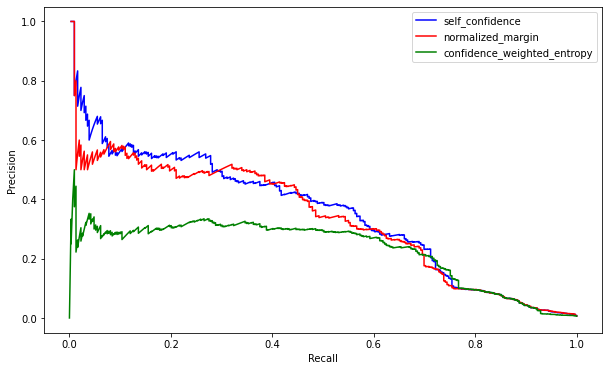

In [8]:
methods = ["self_confidence", "normalized_margin", "confidence_weighted_entropy"] 
colors = ['blue', 'red', 'green'] 

print('{:30}{:10}{:10}{:10}'.format('', 'AUPRC', 'AUPRC', 'Lift @ Error')) 
plt.figure(figsize=(10, 6)) 
for color, method in zip(colors, methods): 
    scores = get_label_quality_scores(labels, pred_probs, method=method) 
    ranking = np.argsort(scores) 
    error_retrival = [errors[r] for r in ranking] 
    
    error_counts = [] 
    for e in error_retrival: 
        if len(error_counts) == 0: 
            error_counts.append(int(e)) 
        else: 
            error_counts.append(error_counts[-1] + int(e)) 

    precision = error_counts / (np.arange(len(error_retrival)) + 1) 
    recall = error_counts / n_error 
    
    fpr, tpr, thresholds = metrics.roc_curve(errors, -scores) 
    auroc = np.round(metrics.auc(fpr, tpr), 4) 
    auprc = np.round(metrics.auc(recall, precision), 4) 
    lift = np.round(precision[n_error] / error_percentage, 4) 
    
    print('{:30}{:<10}{:<10}{:<10}'.format(method, auprc, auroc, lift)) 
    
    plt.plot(recall, precision, color=color) 
    
plt.legend(methods) 
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.savefig('token-level.png', dpi=400) 
plt.show() 